![STSCI banner](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# Turning off `DO_NOT_USE` pixels in the JWST pipeline

**Author**: Néstor Espinoza (Assistant Astronomer; Mission Scientist for Exoplanet Science) <br>
**Last Updated**: July 27, 2023<br>

## 1.<font color='white'>-</font>Introducing the problem <a class="anchor" id="intro"></a>

When downloading JWST products, too many pixels are currently marked as `DO_NOT_USE` pixels by the JWST pipeline. The JWST ramp-fitting step turns all `DO_NOT_USE` pixels to `nan`. Some of those `nan` might be good for science with NIRISS/SOSS.

## 2.<font color='white'>-</font>Studying the problem in an example dataset <a class="anchor" id="inputs"></a>

### 2.1 Downloading data from MAST
To visualize the problem, let's download some NIRISS/SOSS data products from [MAST using `astroquery`](https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search) for [PID 1366](https://www.stsci.edu/jwst/science-execution/program-information?id=1366), the transiting exoplanet ERS program. In particular, let's get the data for WASP-39 b, which uses SUBSTRIP256:

In [1]:
from astroquery.mast import Observations

observation = Observations.query_criteria(instrument_name = 'NIRISS/SOSS', proposal_id = '1366', 
                                          target_name = 'WASP-39')

In terms of data, let's get three sets of [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/product_types.html): the `uncal` data (i.e., the data without any calibrations applied to them), the `ramp` data (i.e., the calibrated groups per integration) and the `rateint` products (i.e., the rates per integration) contained in that exposure, but only for the last segment of the data (which is the one that has the smaller filesize):

In [2]:
# Get data products:
data_products = Observations.get_product_list(observation)

# Filter them to get ramps and rateints; only for the fourth segment of data:
uncals = Observations.filter_products(data_products, productType = 'SCIENCE', productSubGroupDescription = 'UNCAL', 
                                      obs_id = 'jw01366001001_04101_00001-seg004_nis')

ramps = Observations.filter_products(data_products, productType = 'AUXILIARY', productSubGroupDescription = 'RAMP', 
                                      obs_id = 'jw01366001001_04101_00001-seg004_nis')

rateints = Observations.filter_products(data_products, productType = 'SCIENCE', productSubGroupDescription = 'RATEINTS',
                                     obs_id = 'jw01366001001_04101_00001-seg004_nis')

Let's download the data:

In [3]:
Observations.download_products(uncals)
Observations.download_products(ramps)
Observations.download_products(rateints)

Local Path,Status,Message,URL
str107,str8,object,object
./mastDownload/JWST/jw01366001001_04101_00001-seg004_nis/jw01366001001_04101_00001-seg004_nis_rateints.fits,COMPLETE,None,None


### 2.2 Checking the `rateint`, `ramp` and `uncal` products

Now let's load the data and plot one of the rates per integration --- let's paint all `nan`'s in red:

In [4]:
from jwst import datamodels

uncal = datamodels.RampModel('mastDownload/JWST/jw01366001001_04101_00001-seg004_nis/jw01366001001_04101_00001-seg004_nis_uncal.fits')
ramp = datamodels.RampModel('mastDownload/JWST/jw01366001001_04101_00001-seg004_nis/jw01366001001_04101_00001-seg004_nis_ramp.fits')
rateint = datamodels.open('mastDownload/JWST/jw01366001001_04101_00001-seg004_nis/jw01366001001_04101_00001-seg004_nis_rateints.fits')

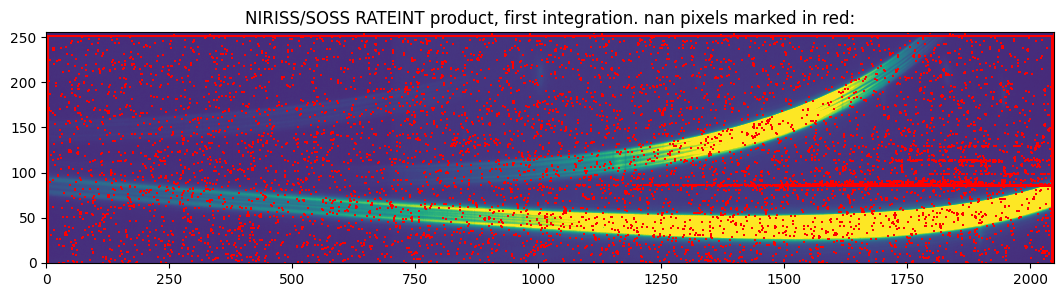

In [5]:
import matplotlib
import matplotlib.pyplot as plt

# Generate a plot of the first rate per integration:
plt.figure(figsize=(13,3))

plt.title('NIRISS/SOSS RATEINT product, first integration. nan pixels marked in red:')
im = plt.imshow(rateint.data[0,:,:], aspect = 'auto', origin = 'lower')

# Color `nan` as red:
cm = im.get_cmap()
cm.set_bad(color = 'red')

im.set_clim(-10,100)

The red pixels above are all `nan` --- and they are a lot! Most of them map 1-to-1 to `DO_NOT_USE` pixels on the `ramp` products. To see this, let's create an array that marks all the `DO_NOT_USE` pixels in those `ramp` products that existe on the `pixeldq` datra quality flags:

In [7]:
import numpy as np
from jwst.datamodels import dqflags

donotuse_array = np.zeros(rateint.data[0,:,:].shape)
donotuse_count = 0

for i in range(256):
    
    for j in range(2048):
        
        tple = dqflags.dqflags_to_mnemonics(ramp.pixeldq[i, j], mnemonic_map = dqflags.pixel)
        
        if 'DO_NOT_USE' in tple:

            donotuse_count += 1
            donotuse_array[i,j] = np.nan

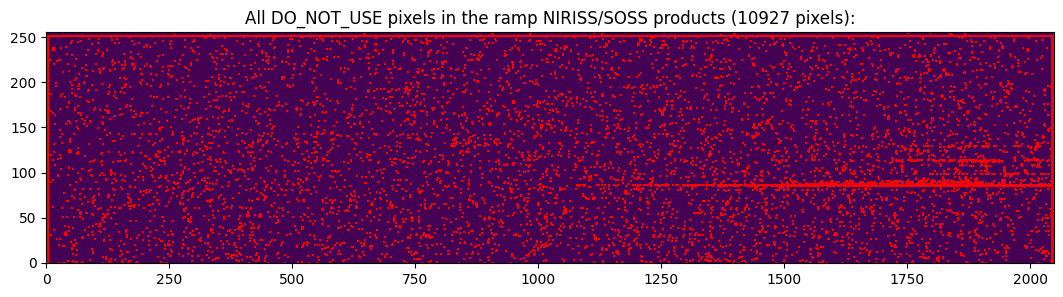

In [8]:
# Plot all the DO_NOT_USE pixels in the ramp products:

plt.figure(figsize=(13,3))

plt.title('All DO_NOT_USE pixels in the ramp NIRISS/SOSS products ('+str(donotuse_count)+' pixels):')

im = plt.imshow(donotuse_array, aspect = 'auto', origin = 'lower')
# Color `nan` as red:
cm = im.get_cmap()
cm.set_bad(color = 'red')

im.set_clim(0,1)

Note, however, not all of those are marked as `DO_NOT_USE` in the NIRISS bad pixel mask, which we can attach to our `uncal` products if we run the `dqinit` step of the JWST pipeline:

In [9]:
from jwst.pipeline import calwebb_detector1

dqinit = calwebb_detector1.dq_init_step.DQInitStep.call(uncal)

2023-07-27 14:02:43,780 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-07-27 14:02:43,832 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(63, 9, 256, 2048) from jw01366001001_04101_00001-seg004_nis_uncal.fits>,).
2023-07-27 14:02:43,833 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-07-27 14:02:43,856 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/jwst/references/jwst/jwst_niriss_mask_0017.fits
2023-07-27 14:02:45,312 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-07-27 14:02:45,945 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-27 14:02:45,946 - stpipe.DQInitStep - INFO - Step DQInitStep done


Let's see which pixels are marked as `DO_NOT_USE` there:

In [10]:
donotuse_array_uncal = np.zeros(rateint.data[0,:,:].shape)
donotuse_count_uncal = 0

for i in range(256):
    
    for j in range(2048):
        
        tple = dqflags.dqflags_to_mnemonics(dqinit.pixeldq[i, j], mnemonic_map = dqflags.pixel)
        
        if 'DO_NOT_USE' in tple:

            donotuse_count_uncal += 1
            donotuse_array_uncal[i,j] = np.nan

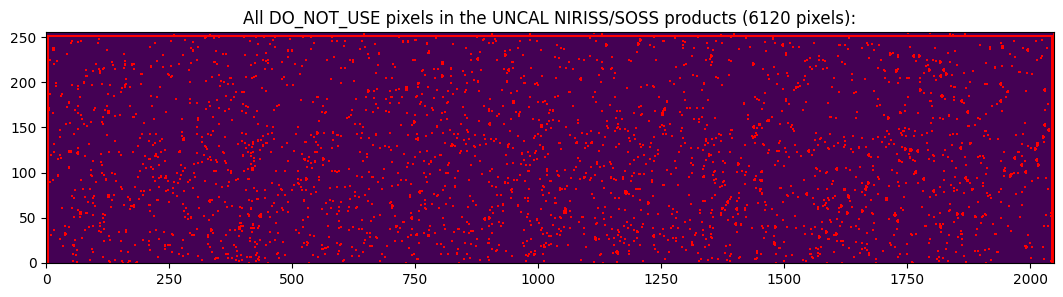

In [11]:
# Plot all the DO_NOT_USE pixels on the uncal data:

plt.figure(figsize=(13,3))

plt.title('All DO_NOT_USE pixels in the UNCAL NIRISS/SOSS products ('+str(donotuse_count_uncal)+' pixels):')

im = plt.imshow(donotuse_array_uncal, aspect = 'auto', origin = 'lower')

# Color `nan` as red:
cm = im.get_cmap()
cm.set_bad(color = 'red')

im.set_clim(0,1)

A much lower number of pixels (~4,000).

## 3.<font color='white'>-</font>Workaround<a class="anchor" id="bye"></a>

One workaround is to simply mark all the `DO_NOT_USE` pixels in the `ramp` products to pixels that can be used (either via the `pixeldq` and/or `groupdq`, setting those to `0` --- which would mean setting those to OK pixels to use), and then run the ramp-fitting step once again. One can then study the `rateint` products from this procedure to identify bad pixels at a later stage. 

Let's do this for the `ramp` products, first for the `pixeldq`:

In [12]:
for i in range(256):
    
    for j in range(2048):
        
        tple = dqflags.dqflags_to_mnemonics(ramp.pixeldq[i, j], mnemonic_map = dqflags.pixel)
        
        if 'DO_NOT_USE' in tple:

            ramp.pixeldq[i, j] = 0

With this, let's run the ramp-fitting step:

In [13]:
rampfit = calwebb_detector1.ramp_fit_step.RampFitStep.call(ramp)

2023-07-27 14:03:55,259 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2023-07-27 14:03:55,319 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(63, 9, 256, 2048) from jw01366001001_04101_00001-seg004_nis_ramp.fits>,).
2023-07-27 14:03:55,320 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}
2023-07-27 14:03:55,968 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /grp/crds/jwst/references/jwst/jwst_niriss_readnoise_0005.fits
2023-07-27 14:03:55,969 - stpipe.RampFitStep - INFO - Using GAIN reference file: /grp/crds/jwst/references/jwst/jwst_niriss_gain_0006.fits
2023-07-27

Let's explore the very first integration, as above:

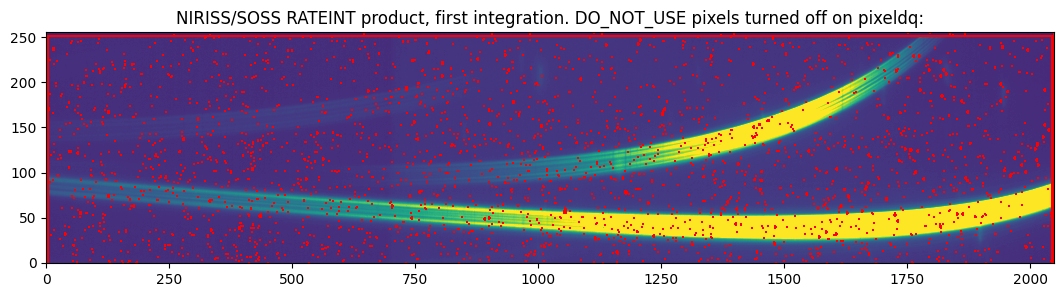

In [14]:
# Generate a plot of the first rate per integration:
plt.figure(figsize=(13,3))

plt.title('NIRISS/SOSS RATEINT product, first integration. DO_NOT_USE pixels turned off on pixeldq:')
im = plt.imshow(rampfit[1].data[0,:,:], aspect = 'auto', origin = 'lower')

# Color `nan` as red:
cm = im.get_cmap()
cm.set_bad(color = 'red')

im.set_clim(-10,100)

That looks much better. There are still some reminder `nan` in some pixels --- those come from `DO_NOT_USE` pixels in the `groupdq` extension in the `ramp` products. One can turn those off too, if desired, with the following procedure, which simply identifies `DO_NOT_USE` pixels in the first integration, first group, and sets that off for all groups and integrations:

In [15]:
for i in range(256):
            
    for j in range(2048):

        tple = dqflags.dqflags_to_mnemonics(ramp.groupdq[0, 0, i, j], mnemonic_map = dqflags.pixel)
        
        if 'DO_NOT_USE' in tple:
        
             ramp.groupdq[:, :, i, j] = 0

Let's re-run the rampfitting step:

In [16]:
rampfit2 = calwebb_detector1.ramp_fit_step.RampFitStep.call(ramp)

2023-07-27 14:06:13,217 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2023-07-27 14:06:13,300 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(63, 9, 256, 2048) from jw01366001001_04101_00001-seg004_nis_ramp.fits>,).
2023-07-27 14:06:13,301 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}
2023-07-27 14:06:13,405 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /grp/crds/jwst/references/jwst/jwst_niriss_readnoise_0005.fits
2023-07-27 14:06:13,406 - stpipe.RampFitStep - INFO - Using GAIN reference file: /grp/crds/jwst/references/jwst/jwst_niriss_gain_0006.fits
2023-07-27

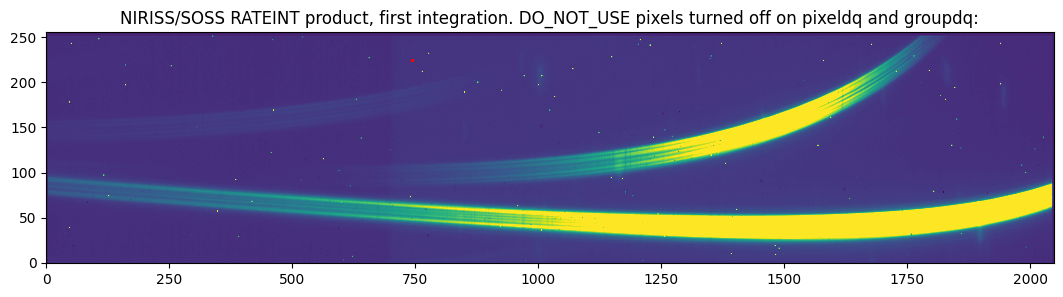

In [17]:
# Generate a plot of the first rate per integration:
plt.figure(figsize=(13,3))

plt.title('NIRISS/SOSS RATEINT product, first integration. DO_NOT_USE pixels turned off on pixeldq and groupdq:')
im = plt.imshow(rampfit2[1].data[0,:,:], aspect = 'auto', origin = 'lower')

# Color `nan` as red:
cm = im.get_cmap()
cm.set_bad(color = 'red')

im.set_clim(-10,100)

And all the `DO_NOT_USE` pixels that were marked as `nan` are now gone. 

Note we have done this here for only the fourth data segment --- in order to apply this to a real full segmented dataset, one would need to apply the above procedures to all segments of the data.